# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [17]:
# Import statements
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers, regularizers
from keras.regularizers import l2
import keras

import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [18]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [19]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 30 #experiment with the batch size

# Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [20]:
x_dim_img = 100
y_dim_img = 100

def image_normalization_std(img):
    normalized_image= (img - np.mean(img))/np.std(img)
    return normalized_image

def image_normalization_minmax(img):
    normalized_image= (img - np.min(img))/(np.max(img)- np.min(img))
    return normalized_image

def image_normalization_pixel(img):
    return img/255

# Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.
def generator_2D(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0, 30, 3)) # create a list of image numbers you want to use for a particular video
    #img_idx = list(range(0, 29)) # create a list of image numbers you want to use for a particular video
    x, y, z = len(img_idx), x_dim_img, y_dim_img
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    resizedImage = imresize(image, (y, z))
                    
                    batch_data[folder,idx,:,:,0] = image_normalization_pixel(resizedImage[:, : , 0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_normalization_pixel(resizedImage[:, : , 1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_normalization_pixel(resizedImage[:, : , 2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

    
        # write the code for the remaining data points which are left after full batches
        if len(folder_list) > num_batches * batch_size:
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    resizedImage = imresize(image, (y, z))
                    
                    batch_data[folder,idx,:,:,0] = image_normalization_pixel(resizedImage[:, : , 0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_normalization_pixel(resizedImage[:, : , 1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_normalization_pixel(resizedImage[:, : , 2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [21]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


# Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# Conv 2D with GRU Model:

In [22]:
class CNN2DWithGRU:
    def __init__(self):
        return None
    
    def get_model(self, batch_size):
        
        regv = 0.01
        cnn_model = Sequential()
        
        cnn_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(10, x_dim_img, y_dim_img, 3)))
        #cnn_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(29, x_dim_img, y_dim_img, 3)))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(regv), bias_regularizer=l2(regv))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dropout(0.25))
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(regv), bias_regularizer=l2(regv))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(Dropout(0.25))
        cnn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(regv), bias_regularizer=l2(regv))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(Dropout(0.50))
        cnn_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(regv), bias_regularizer=l2(regv))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(Flatten()))
        cnn_model.add(Dense(16))
        cnn_model.add(Dropout(.50))
        cnn_model.add(GRU(64, return_sequences=False))
        cnn_model.add(Dense(5, activation='softmax'))
    
        return cnn_model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [23]:
cnn2dgru = CNN2DWithGRU()
model = cnn2dgru.get_model(batch_size)

regv = 0.01
optimiser = optimizers.SGD(lr=regv) #write your optimizer
#optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, 10, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 10, 100, 100, 32)  0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 10, 49, 49, 32)    0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 10, 49, 49, 32)    128       
_________________________________________________________________
time_distributed_25 (TimeDis (None, 10, 49, 49, 32)    9248      
_________________________________________________________________
time_distributed_26 (TimeDis (None, 10, 49, 49, 32)    0         
_________________________________________________________________
time_distributed_27 (TimeDis (None, 10, 24, 24, 32)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [24]:
train_generator = generator_2D(train_path, train_doc, batch_size)
val_generator = generator_2D(val_path, val_doc, batch_size)

In [25]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 2, verbose = 1, mode = "auto", cooldown = 0) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [26]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [27]:
cnn_rnn_model = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 30


/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Epoch 1/30
21/23 [==========================>...] - ETA: 4s - loss: 5.2537 - categorical_accuracy: 0.2095

/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - ETA: 0s - loss: 5.2462 - categorical_accuracy: 0.2159Source path =  ./Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2020-12-2822_09_17.151435/model-00001-5.24621-0.21594-5.20507-0.20000.h5
23/23 [==============================] - 66s 3s/step - loss: 5.2462 - categorical_accuracy: 0.2159 - val_loss: 5.2051 - val_categorical_accuracy: 0.2000
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 5.1662 - categorical_accuracy: 0.2507
Epoch 00002: saving model to model_init_2020-12-2822_09_17.151435/model-00002-5.16622-0.25072-5.17106-0.21667.h5
23/23 [==============================] - 62s 3s/step - loss: 5.1662 - categorical_accuracy: 0.2507 - val_loss: 5.1711 - val_categorical_accuracy: 0.2167
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 5.1054 - categorical_accuracy: 0.2870
Epoch 00003: saving model to model_init_2020-12-2822_09_17.151435/model-00003-5.10544-0.28696-5.13714-0.20833

Epoch 23/30
23/23 [==============================] - ETA: 0s - loss: 3.6297 - categorical_accuracy: 0.8014
Epoch 00023: saving model to model_init_2020-12-2822_09_17.151435/model-00023-3.62971-0.80145-3.98072-0.71667.h5
23/23 [==============================] - 59s 3s/step - loss: 3.6297 - categorical_accuracy: 0.8014 - val_loss: 3.9807 - val_categorical_accuracy: 0.7167
Epoch 24/30
23/23 [==============================] - ETA: 0s - loss: 3.6357 - categorical_accuracy: 0.7957
Epoch 00024: saving model to model_init_2020-12-2822_09_17.151435/model-00024-3.63575-0.79565-3.93358-0.66667.h5
23/23 [==============================] - 60s 3s/step - loss: 3.6357 - categorical_accuracy: 0.7957 - val_loss: 3.9336 - val_categorical_accuracy: 0.6667
Epoch 25/30
23/23 [==============================] - ETA: 0s - loss: 3.6122 - categorical_accuracy: 0.8029
Epoch 00025: saving model to model_init_2020-12-2822_09_17.151435/model-00025-3.61223-0.80290-3.98342-0.66667.h5
23/23 [===========================

In [28]:
class PlotEvaluationMetrics():
    
    def plot_graph(self, history):
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
        f.set_figheight(5)
        f.set_figwidth(15)
        
        ax1.plot(history.history['categorical_accuracy'])
        ax1.plot(history.history['val_categorical_accuracy'])
        ax1.title.set_text('Accuracy')
        ax1.set_ylabel('accuracy')
        ax1.set_xlabel('epoch')
        ax1.legend(['train', 'test'], loc='upper left')
        
        ax2.plot(history.history['loss'])
        ax2.plot(history.history['val_loss'])
        ax2.title.set_text('Loss function')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('epoch')
        ax2.legend(['train', 'test'], loc='upper left')
        
        plt.show()
        
def print_evaluation_metrics(obj, epoch):
    print("Training Loss: ", obj.history['loss'][epoch-1])
    print("Training Accuracy: ", obj.history['categorical_accuracy'][epoch-1])
    print("Validation Loss: ", obj.history['val_loss'][epoch-1])
    print("Validation Accuracy: ", obj.history['val_categorical_accuracy'][epoch-1])

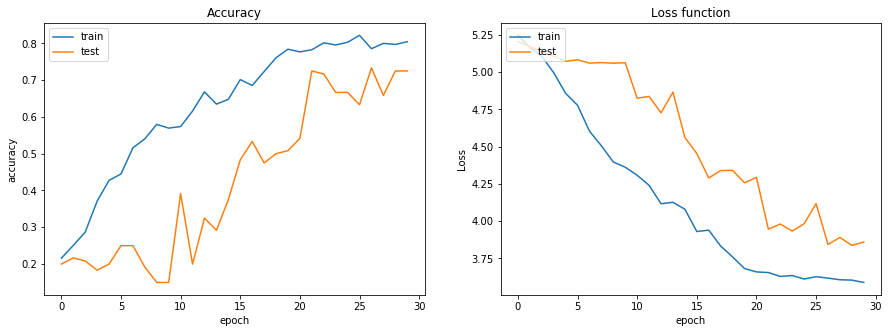

Conv 2D with GRU model:
Training Loss:  3.589263916015625
Training Accuracy:  0.804347813129425
Validation Loss:  3.8603084087371826
Validation Accuracy:  0.7250000238418579


In [29]:
plotting_obj = PlotEvaluationMetrics()
plotting_obj.plot_graph(cnn_rnn_model)
print("Conv 2D with GRU model:")
print_evaluation_metrics(cnn_rnn_model, num_epochs)

## Conv3D Model:

In [38]:
# batch_size = 30
# num_epochs = 10

In [39]:
# # Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.
# def generator_3D(source_path, folder_list, batch_size):
#     print( 'Source path = ', source_path, '; batch size =', batch_size)
#     #img_idx = list(range(0, 30, 3)) # create a list of image numbers you want to use for a particular video
#     img_idx = list(range(0, 29)) # create a list of image numbers you want to use for a particular video
#     x, y, z = len(img_idx), x_dim_img, y_dim_img
    
#     while True:
#         t = np.random.permutation(folder_list)
#         num_batches = len(folder_list)//batch_size # calculate the number of batches
        
#         for batch in range(num_batches): # we iterate over the number of batches
#             batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
#             batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
#             for folder in range(batch_size): # iterate over the batch_size
#                 imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
#                 for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
#                     image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
#                     #crop the images and resize them. Note that the images are of 2 different shape 
#                     #and the conv3D will throw error if the inputs in a batch have different shapes
                    
#                     resizedImage = imresize(image, (y, z))
                    
#                     batch_data[folder,idx,:,:,0] = image_normalization_pixel(resizedImage[:, : , 0]) #normalise and feed in the image
#                     batch_data[folder,idx,:,:,1] = image_normalization_pixel(resizedImage[:, : , 1]) #normalise and feed in the image
#                     batch_data[folder,idx,:,:,2] = image_normalization_pixel(resizedImage[:, : , 2]) #normalise and feed in the image
                    
#                 batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#             yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

    
#         # write the code for the remaining data points which are left after full batches
#         if len(folder_list) > num_batches * batch_size:
#             batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
#             batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
#             for folder in range(batch_size): # iterate over the batch_size
#                 imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
#                 for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
#                     image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
#                     #crop the images and resize them. Note that the images are of 2 different shape 
#                     #and the conv3D will throw error if the inputs in a batch have different shapes
                    
#                     resizedImage = imresize(image, (y, z))
                    
#                     batch_data[folder,idx,:,:,0] = image_normalization_pixel(resizedImage[:, : , 0]) #normalise and feed in the image
#                     batch_data[folder,idx,:,:,1] = image_normalization_pixel(resizedImage[:, : , 1]) #normalise and feed in the image
#                     batch_data[folder,idx,:,:,2] = image_normalization_pixel(resizedImage[:, : , 2]) #normalise and feed in the image
                    
#                 batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#             yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [40]:
# num_classes = 5
# regv = 0.01
# model = Sequential()

# model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(29,x_dim_img, y_dim_img, 3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))


# model.add(Conv3D(64, (3, 3, 3), padding='same', input_shape=(29,x_dim_img, y_dim_img, 3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, (3, 3, 3), padding='same', input_shape=(29,x_dim_img, y_dim_img, 3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())
# model.add(Dropout(0.5))
# model.add(Dense(512,kernel_regularizer=l2(regv)))
# model.add(Activation('relu'))
# model.add(Dense(num_classes))
# model.add(Activation('softmax')) 

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [41]:
# regv = 0.01
# optimiser = optimizers.SGD(lr=regv) #write your optimizer
# #optimiser = optimizers.Adam()
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [42]:
# train_generator = generator_3D(train_path, train_doc, batch_size)
# val_generator = generator_3D(val_path, val_doc, batch_size)

In [43]:
# model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
# if not os.path.exists(model_name):
#     os.mkdir(model_name)
        
# filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
# callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [44]:
# if (num_train_sequences%batch_size) == 0:
#     steps_per_epoch = int(num_train_sequences/batch_size)
# else:
#     steps_per_epoch = (num_train_sequences//batch_size) + 1

# if (num_val_sequences%batch_size) == 0:
#     validation_steps = int(num_val_sequences/batch_size)
# else:
#     validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [45]:
# model = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [46]:
# plotting_obj = PlotEvaluationMetrics()
# plotting_obj.plot_graph(model)
# print("Conv 3D model:")
# print_evaluation_metrics(model, num_epochs)